In [1]:
import torch
from diffusers.models import AutoencoderKL
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
sd_decoder = vae.decoder
for p in sd_decoder.parameters():
    p.requires_grad = False
sd_decoder.eval()
sd_decoder = sd_decoder.cuda()
sd_decoder

/home/teekh/workspace/git_personal/image-detection-model-experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Decoder(
  (conv_in): Conv2d(4, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up_blocks): ModuleList(
    (0-1): 2 x UpDecoderBlock2D(
      (resnets): ModuleList(
        (0-2): 3 x ResnetBlock2D(
          (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
          (conv1): LoRACompatibleConv(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (upsamplers): ModuleList(
        (0): Upsample2D(
          (conv): LoRACompatibleConv(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): UpDecoderBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
          (conv1): LoRACompatibleConv(51

In [2]:
import os
import pandas as pd
from tqdm import tqdm
from glob import glob
from dotenv import load_dotenv
import torch
from torch import optim
from torch.utils.data import DataLoader
from utils.plot_image import image_gallery, plot_reconstructions


load_dotenv(override=True)

LOCAL_BUCKET_FOLDER = os.getenv("LOCAL_BUCKET_FOLDER")
EXPERIMENT_FOLDER = "experiment_1"

In [3]:
images_folder = LOCAL_BUCKET_FOLDER
images = glob(images_folder + "/**/*.jpg", recursive=True)
images = list(set(images))
images_df = pd.DataFrame(images, columns=["image_path"])
print('total:',len(images_df))
def images_split(images_df: pd.DataFrame, train_size: float = 0.85, val_size: float = 0.1, test_size: float = 0.05, random_state: int = 42):
    assert train_size + val_size + test_size == 1
    train_df = images_df.sample(frac=train_size, random_state=random_state)
    val_df = images_df.drop(train_df.index).sample(frac=val_size / (1 - train_size), random_state=random_state)
    test_df = images_df.drop(train_df.index).drop(val_df.index)
    return train_df, val_df, test_df

train_df, val_df, test_df = images_split(images_df)
train_df.reset_index(drop=True, inplace=True)  # Reset the index of train_df
val_df.reset_index(drop=True, inplace=True)  # Reset the index of val_df
test_df.reset_index(drop=True, inplace=True)  # Reset the index of test_df

print('train:',len(train_df))
print('val:',len(val_df))
print('test',len(test_df))

total: 19592
train: 16653
val: 1959
test 980


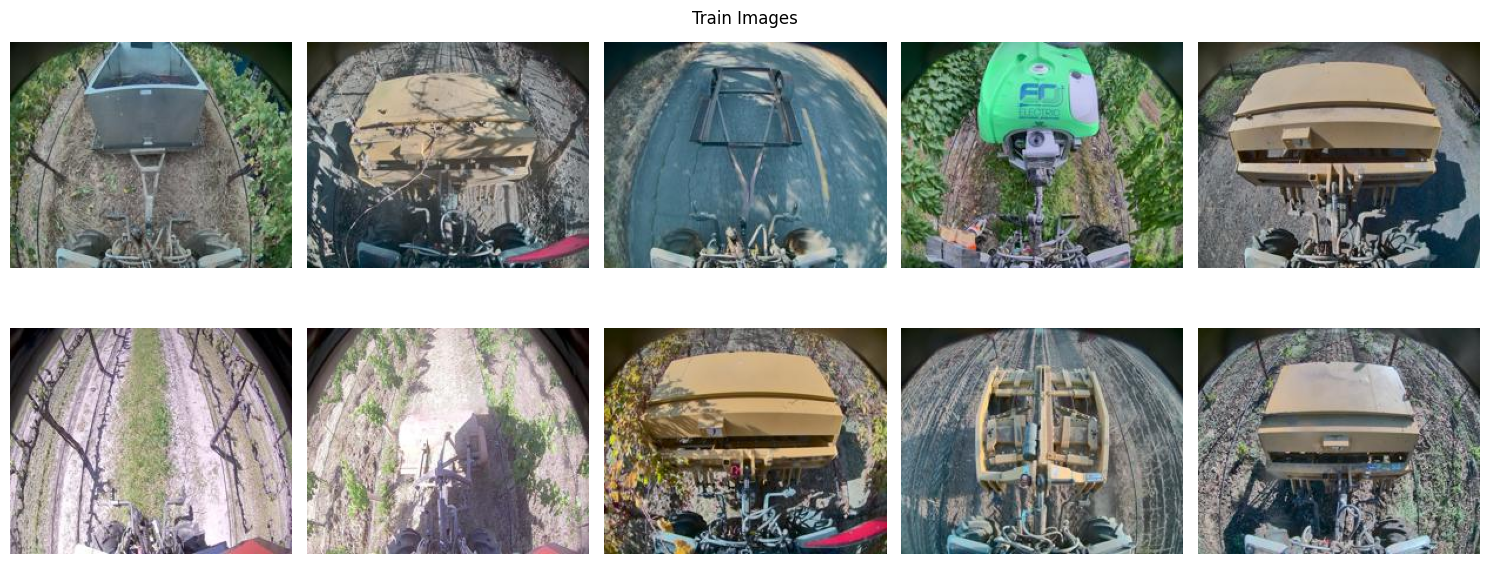

In [4]:
image_gallery(train_df.sample(15).image_path.tolist(), title="Train Images")

In [5]:
from experiment_1.dataset import AEDataset
from experiment_1.model import VariationalAutoencoder
train_ds = AEDataset(train_df.image_path)
val_ds = AEDataset(val_df.image_path)
test_ds = AEDataset(test_df.image_path)

dl_config = {
    "batch_size": 4,
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True,
    "drop_last": True,
}

train_dl = DataLoader(train_ds, **dl_config)
val_dl = DataLoader(val_ds, **dl_config)
test_dl = DataLoader(test_ds, **dl_config)
next(iter(train_dl)).shape

torch.Size([4, 3, 192, 240])

In [6]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from experiment_1.model import VariationalAutoencoder, VariationalEncoder
from experiment_1.dataset import AEDataset
from tqdm import tqdm


ae = VariationalAutoencoder(use_stable_diffusion=False)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('ae')
print(count_params(ae.encoder))
print(count_params(ae.decoder))
print(count_params(ae))

del ae

ae
1066716
33655523
34722239


In [7]:
train_config = {
    'lr': 1e-3,
    'epochs': 32,
    'device': 'cuda',
}

def create_criterion(a:float, b:float):
    mse_criterion = torch.nn.MSELoss()
    mae_criterion = torch.nn.L1Loss()
    def criterion(outputs, mean, log_var, batch):
        mse_loss = mse_criterion(outputs, batch)
        mae_loss = mae_criterion(outputs, batch)
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=None)
        all_losses = {
            'mse': mse_loss.item(),
            'mae': mae_loss.item(),
            'kl': kl_loss.item(),
        }
        return a * mse_loss + (1 - a) * mae_loss + b * kl_loss, all_losses
    return criterion

def pretty_print_losses(all_losses: dict, epoch: int, running_loss:float, lr:float):
    epoch_report = f"Epoch: {epoch}, Loss: {running_loss:.6f}, LR: {lr:.6f}" 
    losses_report = "|".join([f"{k}: {v:.6f}" for k, v in all_losses.items()])
    return f"{epoch_report}, {losses_report}"

def initialize_training(lr:float, device:str):
    model = VariationalAutoencoder(.02).to(torch.bfloat16).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = create_criterion(.999, .000001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, verbose=False, factor=.95)
    return model, optimizer, criterion, scheduler
model, optimizer, criterion, scheduler = initialize_training(lr=train_config['lr'], device=train_config['device'])

In [8]:
@torch.no_grad()
def evaluate_loss(model, criterion, dataloader, device, dtype):
    model.eval()
    eval_running_loss = 0
    for batch in dataloader:
        batch = batch.to(device).to(dtype)
        outputs, mean, logvar = model(batch)
        loss, all_losses = criterion(outputs, mean, logvar, batch)
        eval_running_loss += loss.item()
    return eval_running_loss / len(dataloader)

def train(model, optimizer, criterion, scheduler, train_dl, val_dl, epochs:int, device='cuda', dtype=torch.bfloat16, patience:int=5):
    best_val_loss = float('inf')
    epoch_patience = 0
    losses = []
    reporting_start_step = 60
    for epoch in range(epochs):
        epoch_patience += 1
        model.train()
        train_loss = 0
        pbar = tqdm(train_dl)
        step = 1
        for batch in pbar:
            optimizer.zero_grad()
            batch = batch.to(dtype).to(device)
            outputs, mean, logvar = model(batch)
            loss, all_losses = criterion(outputs, mean, logvar, batch)
            loss.backward()
            optimizer.step()
           
            losses.append((loss.item(), all_losses['mse'], all_losses['mae']))
            lr = optimizer.param_groups[0]['lr']
            
            if step > reporting_start_step:
                train_loss += loss.item()
                
                running_train_loss = train_loss / (step - reporting_start_step)
                pbar.set_description(
                    pretty_print_losses(all_losses, epoch, running_train_loss, lr)
                    #f"Epoch {epoch+1}/{epochs} - loss: {running_train_loss:.6f}, lr: {lr:.6f}, mse: {all_losses['mse']:.6f}, mae: {all_losses['mae']:.5f}"
                )
            step += 1
            scheduler.step(loss.item())

        train_loss /= len(train_dl)
        val_loss = evaluate_loss(model, criterion, val_dl, device=device, dtype=dtype)

        print(f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.6f} - val_loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{EXPERIMENT_FOLDER}/encoder-decoder.pth')
            torch.save(model.encoder.state_dict(), f'{EXPERIMENT_FOLDER}/encoder.pth')
            epoch_patience = 0
        if epoch_patience >= patience:
            print("Early Stopping")
            break
    return losses

losses = train(model, optimizer, criterion, scheduler, train_dl, val_dl, epochs=train_config['epochs'], device=train_config['device'])

Epoch: 0, Loss: 0.021782, LR: 0.000857, mse: 0.014832|mae: 0.091309|kl: 4256.000000: 100%|██████████| 4163/4163 [13:48<00:00,  5.03it/s]


Epoch 1/32 - train_loss: 0.021468 - val_loss: 0.019779


Epoch: 1, Loss: 0.019444, LR: 0.000569, mse: 0.011475|mae: 0.081055|kl: 3888.000000: 100%|██████████| 4163/4163 [13:39<00:00,  5.08it/s]


Epoch 2/32 - train_loss: 0.019163 - val_loss: 0.019313


Epoch: 2, Loss: 0.019304, LR: 0.000463, mse: 0.018921|mae: 0.105469|kl: 4080.000000:  45%|████▍     | 1863/4163 [06:09<07:36,  5.04it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


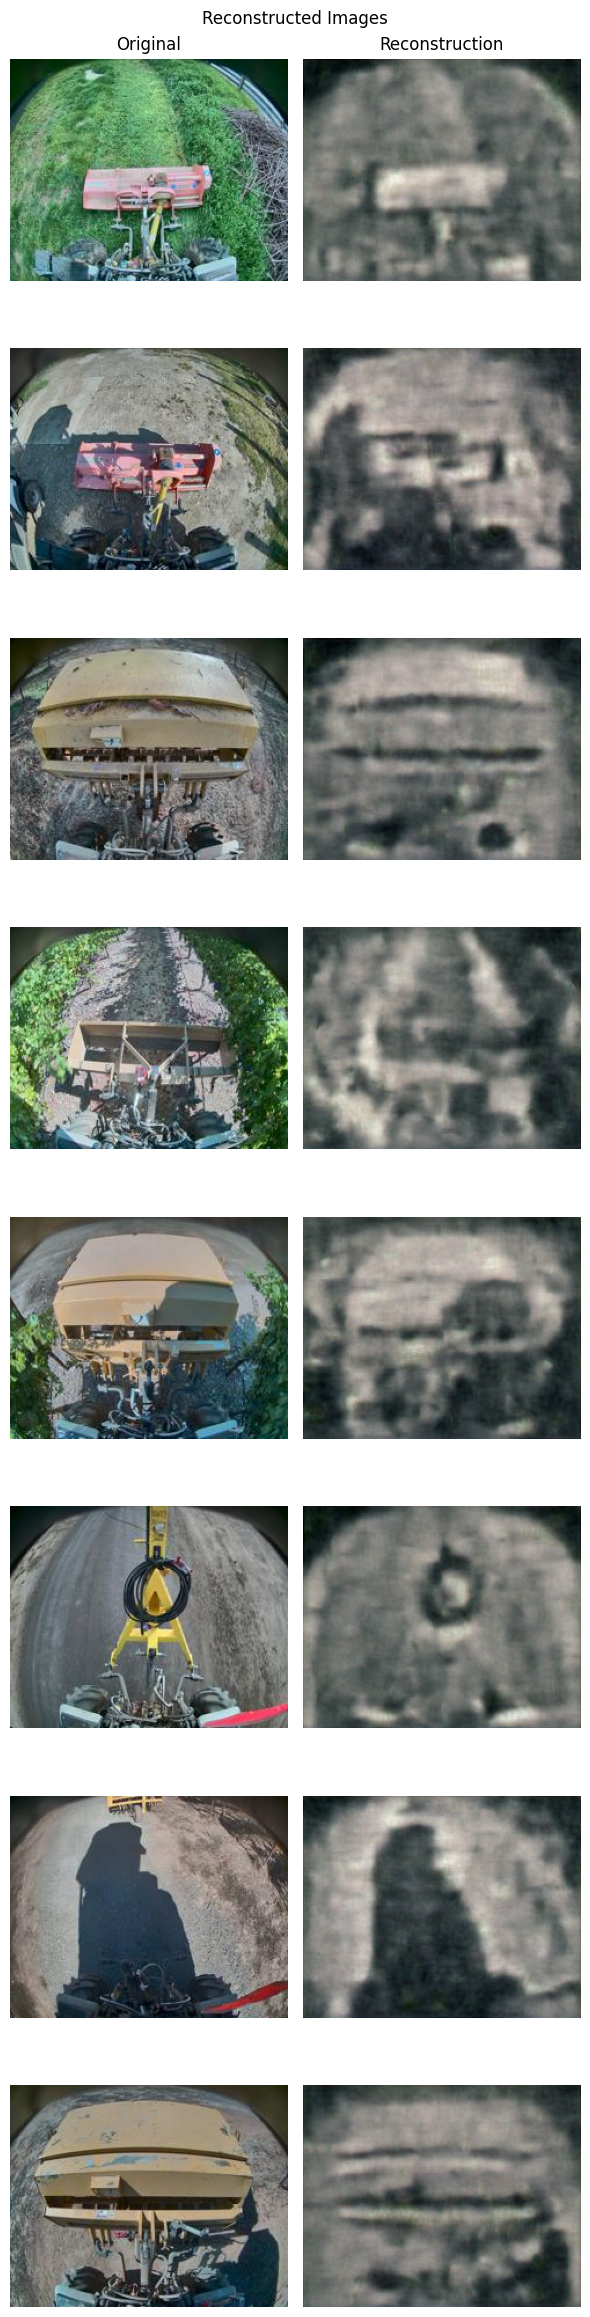

In [ ]:
@torch.no_grad()
def reconstruct_images(model, dataloader, device, dtype, num_batches = 2):
    model.eval()
    comparisons = []

    for b, batch in enumerate(dataloader):
        if b >= num_batches:
            break
        batch = batch.to(device).to(dtype)
        outputs, _, _ = model(batch)
        for i in range(len(batch)):
            comparisons.append((
                batch[i].cpu().to(torch.float32).permute(1, 2, 0).numpy(),
                outputs[i].cpu().to(torch.float32).permute(1, 2, 0).numpy(),
                ))
    return comparisons

comparisons = reconstruct_images(model, test_dl, device=train_config['device'], dtype=torch.bfloat16)
plot_reconstructions(comparisons, title="Reconstructed Images")